In [1]:
import pandas as pd
import pandas
from pandas import DataFrame
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import datetime 
import seaborn as sns
import matplotlib.pyplot as mp
import yfinance as yf
yf.pdr_override()
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

## Data Collection and Feature generation

We begin by generating a dataset that contains the predictors which will be used to make the predictions, and the output variable.

Our dataset is built using raw data comprising of a 3-year price series for IBM stock. The individual stock and index data consists of Date, Open, High, Low, Close and Volume. Using this data we calculated our indicators based on various technical indicators i.e. Rate Of Change(ROC), Momentum (MOM), moving average(MA).

In [2]:
df_4 = pdr.get_data_yahoo('IBM', pd.Timestamp('2018'),pd.Timestamp('2022'))[['Open', 'High', 'Low', 'Close']].rename(columns={'Open': 'IBM_Open','Close':'IBM_Close', 'High':'IBM_High', 'Low':'IBM_Low'})
df_4 = df_4.dropna()
df_4

[*********************100%***********************]  1 of 1 completed


,IBM_Open,IBM_High,IBM_Low,IBM_Close
Date,,,,
2018-01-02,147.705551,148.001907,146.787766,147.466537
2018-01-03,150.420654,152.782028,149.455063,151.520081
2018-01-04,152.629059,155.181641,152.361374,154.588913
2018-01-05,155.296371,155.736145,154.015289,155.344162
2018-01-08,155.506699,156.701721,154.588913,156.281067
...,...,...,...,...
2021-12-27,130.630005,131.649994,129.949997,131.619995
2021-12-28,131.600006,133.220001,131.589996,132.630005
2021-12-29,132.399994,134.210007,132.300003,133.350006


In [3]:
Stocks_df = df_4
# Create short simple moving average over the short window
Stocks_df['short_mavg'] = Stocks_df['IBM_Close'].rolling(window=7, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
Stocks_df['long_mavg'] = Stocks_df['IBM_Close'].rolling(window=12, min_periods=1, center=False).mean()

In [4]:
#calculation of rate of change

def ROC(Stocks_df, n):  
    M = Stocks_df.diff(n - 1)  
    N = Stocks_df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
Stocks_df['IBM_ROC7'] = ROC(Stocks_df['IBM_Close'], 7)
Stocks_df['IBM_ROC12'] = ROC(Stocks_df['IBM_Close'], 12)

#Calculation of price momentum

def MOM(Stocks_df, n):   
    MOM = pd.Series(Stocks_df.diff(n), name='Momentum_' + str(n))   
    return MOM
Stocks_df['IBM_MOM7'] = MOM(Stocks_df['IBM_Close'], 7)
Stocks_df['IBM_MOM12'] = MOM(Stocks_df['IBM_Close'], 12)

#Calculation of moving average

def MA(Stocks_df, n):
    MA = pd.Series(Stocks_df['IBM_Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
Stocks_df['IBM_MA7'] = MA(Stocks_df, 7)
Stocks_df['IBM_MA12'] = MA(Stocks_df, 12)


#Calculation of Relative Strength Index


def rsi(Stocks_df, periods = 7, ema = True):
    
    close_delta = Stocks_df['IBM_Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

Stocks_df['IBM_RSI7'] = rsi(Stocks_df, 7)
Stocks_df['IBM_RSI12'] = rsi(Stocks_df, 12)
Stocks_df = Stocks_df.dropna()
Stocks_df

,IBM_Open,IBM_High,IBM_Low,IBM_Close,short_mavg,long_mavg,IBM_ROC7,IBM_ROC12,IBM_MOM7,IBM_MOM12,IBM_MA7,IBM_MA12,IBM_RSI7,IBM_RSI12
Date,,,,,,,,,,,,,,
2018-01-19,157.227539,158.126190,154.206497,155.229446,157.813442,156.587797,-1.102452,2.448102,-1.395798,7.762909,157.813442,156.587797,47.386859,55.228596
2018-01-22,154.407272,156.768646,154.024857,155.449326,157.597652,156.915234,-0.974428,0.556581,-1.510529,3.929245,157.597652,156.915234,48.382076,55.889407
2018-01-23,155.659653,158.948380,155.363297,158.938812,157.877629,157.277725,1.906341,2.313991,1.959839,4.349899,157.877629,157.277725,61.770882,64.866960
2018-01-24,159.416824,161.300186,157.571701,158.097519,158.182192,157.507172,0.927678,1.162298,2.131943,2.753357,158.182192,157.507172,57.570633,61.571117
2018-01-25,158.613770,159.445511,157.925430,158.193115,158.403442,157.666509,-1.885567,1.001033,1.548752,1.912048,158.403442,157.666509,57.949687,61.811640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,130.630005,131.649994,129.949997,131.619995,128.765714,126.539167,4.518379,6.514522,8.509995,8.599998,128.765714,126.539167,86.577934,77.746867
2021-12-28,131.600006,133.220001,131.589996,132.630005,129.722858,127.294167,4.105183,6.882109,6.700005,9.060005,129.722858,127.294167,88.319834,79.424927
2021-12-29,132.399994,134.210007,132.300003,133.350006,130.572859,128.065835,4.950424,8.786102,5.950005,9.260010,130.572859,128.065835,89.457706,80.564664


In [5]:
#excluding columns that are not needed for our prediction.

Indicator_df=Stocks_df.drop(['IBM_Open','IBM_High','IBM_Low', 'IBM_Close'], axis=1)
Indicator_df.head()

,short_mavg,long_mavg,IBM_ROC7,IBM_ROC12,IBM_MOM7,IBM_MOM12,IBM_MA7,IBM_MA12,IBM_RSI7,IBM_RSI12
Date,,,,,,,,,,
2018-01-19,157.813442,156.587797,-1.102452,2.448102,-1.395798,7.762909,157.813442,156.587797,47.386859,55.228596
2018-01-22,157.597652,156.915234,-0.974428,0.556581,-1.510529,3.929245,157.597652,156.915234,48.382076,55.889407
2018-01-23,157.877629,157.277725,1.906341,2.313991,1.959839,4.349899,157.877629,157.277725,61.770882,64.866960
2018-01-24,158.182192,157.507172,0.927678,1.162298,2.131943,2.753357,158.182192,157.507172,57.570633,61.571117
2018-01-25,158.403442,157.666509,-1.885567,1.001033,1.548752,1.912048,158.403442,157.666509,57.949687,61.811640


## Data Visualization 

The most significant pre-requisite for predictive modeling is to have a good understanding of the dataset. And also visualize the correlation between the various features, obtained from the model improves its accuracy. We would like to see if we have a balanced data or not

<AxesSubplot:xlabel='Date'>

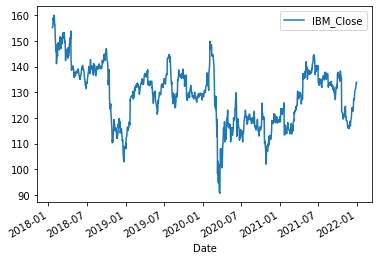

In [6]:
Close_Vis_df = Stocks_df[['IBM_Close']]
Close_Vis_df.plot()

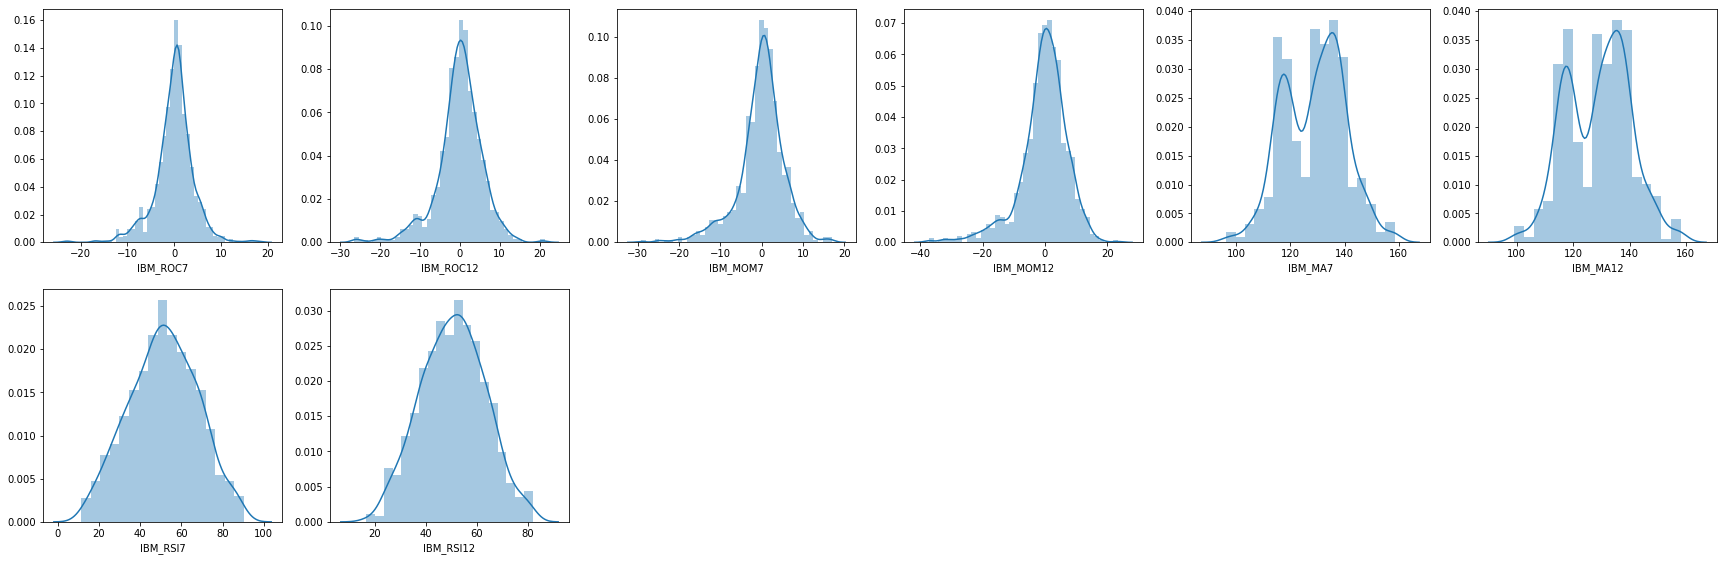

In [7]:
visualize_cols=['IBM_ROC7','IBM_ROC12','IBM_MOM7','IBM_MOM12','IBM_MA7','IBM_MA12','IBM_RSI7','IBM_RSI12']
plt.figure(figsize=(30,30))

for i in range(len(visualize_cols)):
    plt.subplot(6,6,i+1)
    sns.distplot(Indicator_df[visualize_cols[i]])
plt.show()

In [8]:
X = Indicator_df.drop(['long_mavg','IBM_ROC7','IBM_MOM12','IBM_MA7','short_mavg','IBM_RSI12'], axis=1)
y = np.where(Stocks_df.IBM_Close.shift(-1)>Stocks_df['IBM_Close'],1,-1)

            short_mavg  long_mavg  IBM_ROC7  IBM_ROC12  IBM_MOM7  IBM_MOM12  \
short_mavg    1.000000   0.987421 -0.048419   0.080480 -0.011065   0.114551   
long_mavg     0.987421   1.000000 -0.148784  -0.061677 -0.134565  -0.023107   
IBM_ROC7     -0.048419  -0.148784  1.000000   0.752586  0.910547   0.722524   
IBM_ROC12     0.080480  -0.061677  0.752586   1.000000  0.803004   0.949822   
IBM_MOM7     -0.011065  -0.134565  0.910547   0.803004  1.000000   0.785974   
IBM_MOM12     0.114551  -0.023107  0.722524   0.949822  0.785974   1.000000   
IBM_MA7       1.000000   0.987421 -0.048419   0.080480 -0.011065   0.114551   
IBM_MA12      0.987421   1.000000 -0.148784  -0.061677 -0.134565  -0.023107   
IBM_RSI7      0.055770  -0.051963  0.772598   0.795371  0.804606   0.792210   
IBM_RSI12     0.160050   0.048057  0.703226   0.795872  0.751892   0.812285   

             IBM_MA7  IBM_MA12  IBM_RSI7  IBM_RSI12  
short_mavg  1.000000  0.987421  0.055770   0.160050  
long_mavg   0.987421  

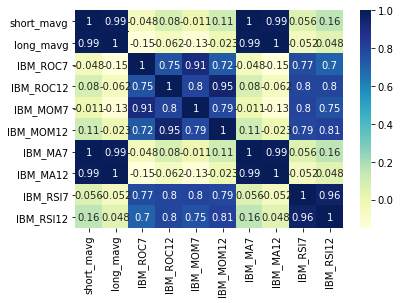

In [9]:
print(Indicator_df.corr())
  
# plotting correlation heatmap
dataplot = sns.heatmap(Indicator_df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mp.show()

## Feature selection

Feature selection is the process of selecting a subset of features that are most relevant for model generation which aid in creating an accurate predictive model. 

In our model, we will use filter method utilising the random.forest.importance function. The random.forest.importance function rates the importance of each feature in the classification of the outcome. The function returns a data frame containing the name of each attribute and the importance value based on the mean decrease in accuracy.

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
forest = RandomForestClassifier()
forest.fit(X, y)

RandomForestClassifier()

           Importance
IBM_ROC12   24.493345
IBM_RSI7    24.576730
IBM_MA12    24.939493
IBM_MOM7    25.990432


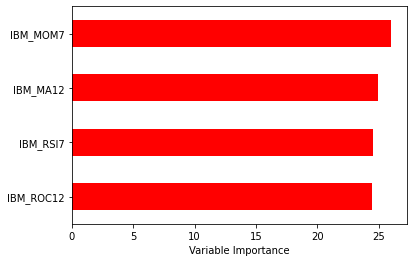

In [12]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Splitting

After creating models for unseen data, we will check their accuracy thanks to statistical methods. We evaluate the accuracy of the best model on actual unseen data to have the estimation more concrete. Meaning that we will use the algorithm on the training set and use the model on the test set afterwards for validation. We split the dataset into 70% training set and 30% test

In [14]:
index = int(0.7*len(X))
X_train = X[:index]
X_test = X[index:]
y_train = y[:index]
y_test = y[index:]

## Modeling

In order to know which algorithm technic is the best for our strategy, we evaluate 3 different methods:

K-Nearest Neighbors (KNN)  
Classification and Regression Trees (CART)  
Random Forest (RF)  

In [15]:
# Spot Check Algorithms


data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('RF', RandomForestClassifier()))

# evaluate each model in turn

results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)
    cv_results =cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.499209 (0.029661)
CART: 0.502127 (0.029254)
RF: 0.515005 (0.035575)


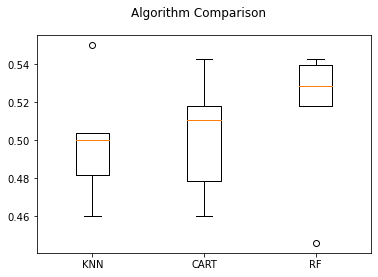

In [16]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Random Forest Classifier

In [17]:
rf = RandomForestClassifier(n_estimators = 500, min_samples_split=5,min_samples_leaf =2,max_features = 4,n_jobs=4,criterion='gini')
predy=rf.fit(X_train, y_train)

In [18]:
predictions = rf.predict(X_test)

In [19]:
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.5451505016722408
[[65 80]
 [56 98]]
              precision    recall  f1-score   support

          -1       0.54      0.45      0.49       145
           1       0.55      0.64      0.59       154

    accuracy                           0.55       299
   macro avg       0.54      0.54      0.54       299
weighted avg       0.54      0.55      0.54       299



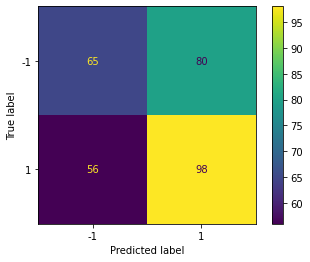

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred= predictions)
plt.show()

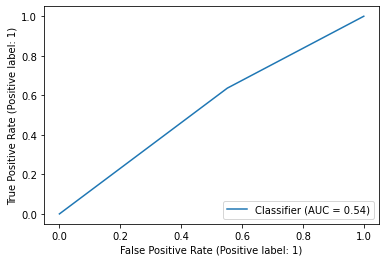

In [26]:
rf_disp = RocCurveDisplay.from_predictions(y_test,y_pred= predictions)
plt.show()

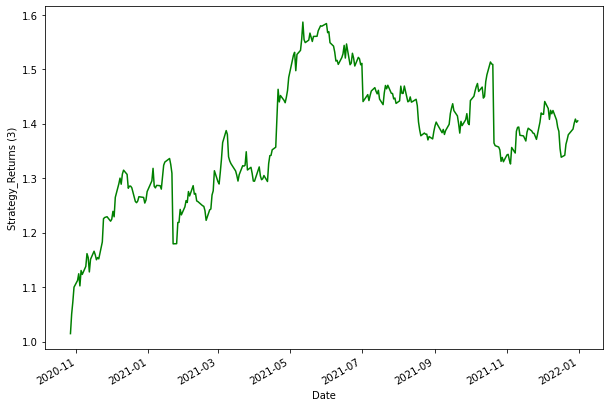

In [22]:
# Predicted Signal
pred_df1 = Stocks_df.iloc[index:]
pred_df1[' true_label'] = y_test
pred_df1['Predicted_Signal' ] = predictions
# Calculate daily returns
pred_df1['Return'] = pred_df1.IBM_Close.pct_change ()
# Calculate strategy returns
pred_df1['Strategy_Return'] = pred_df1.Return * pred_df1.Predicted_Signal.shift(1)
# Calculate geometric returns
geometric_returns = (pred_df1. Strategy_Return.iloc[:index]+1).cumprod()
#geometric_returns
geometric_returns.plot (figsize=(10, 7), color='g')
plt.ylabel ( "Strategy_Returns (3)" )
plt.xlabel("Date")
plt.show()

In [24]:
pred_df1

,IBM_Open,IBM_High,IBM_Low,IBM_Close,short_mavg,long_mavg,IBM_ROC7,IBM_ROC12,IBM_MOM7,IBM_MOM12,IBM_MA7,IBM_MA12,IBM_RSI7,IBM_RSI12,true_label,Predicted_Signal,Return,Strategy_Return
Date,,,,,,,,,,,,,,,,,,
2020-10-26,109.416824,109.847038,106.921608,107.284897,113.064735,116.219725,-10.886998,-12.184051,-12.112808,-18.422562,113.064735,116.219725,21.581365,29.909875,-1,-1,NaN,NaN
2020-10-27,107.217972,107.284897,105.191208,105.697899,110.965583,114.847036,-11.918418,-13.088591,-14.694069,-16.472275,110.965583,114.847036,19.131795,27.796984,-1,-1,-0.014792,0.014792
2020-10-28,103.881454,104.904396,101.261948,101.959846,108.388418,113.209050,-9.133509,-14.748203,-18.040154,-19.655830,108.388418,113.209050,14.583181,23.526498,1,1,-0.035365,0.035365
2020-10-29,102.533463,104.818359,101.864243,104.120461,107.232996,111.919216,-5.345036,-13.522309,-8.087952,-15.478012,107.232996,111.919216,26.385452,30.280402,1,1,0.021191,0.021191
2020-10-30,103.154877,106.883362,103.011475,106.749519,106.768642,110.781548,-3.541810,-10.593324,-3.250481,-13.652008,106.768642,110.781548,38.457181,37.596274,1,1,0.025250,0.025250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,130.630005,131.649994,129.949997,131.619995,128.765714,126.539167,4.518379,6.514522,8.509995,8.599998,128.765714,126.539167,86.577934,77.746867,1,1,0.007579,0.007579
2021-12-28,131.600006,133.220001,131.589996,132.630005,129.722858,127.294167,4.105183,6.882109,6.700005,9.060005,129.722858,127.294167,88.319834,79.424927,1,1,0.007674,0.007674
2021-12-29,132.399994,134.210007,132.300003,133.350006,130.572859,128.065835,4.950424,8.786102,5.950005,9.260010,130.572859,128.065835,89.457706,80.564664,1,-1,0.005429,0.005429


## conclusion

In conclusion, we used the return strategy on day to day closing price, to help us understand how is our investment strategy going, but  since our accuracy is 54% therefore, we made relatively huge losses compared to the returns. Our production did not work as we expected in most cases, it made us sell the stock when we should buy it and buy when we needed to sell and that what cost us the most.